# Load ImageNet Model

from transformers import AutoImageProcessor, ViTForImageClassification
from transformer_lens.HookedViT import HookedViT

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch32-224-in21k")
hf_model = ViTForImageClassification.from_pretrained("google/vit-base-patch32-224-in21k").to("cuda")
tl_model = HookedViT.from_pretrained("google/vit-base-patch32-224-in21k").to("cuda")

In [4]:
import torch

hf_model.load_state_dict(torch.load("../models/noise_models/imagenet_vit32/iw1fvz69.pth"))

<All keys matched successfully>

In [10]:
from transformer_lens.loading_from_pretrained import convert_vit_weights

state_dict = convert_vit_weights(hf_model, tl_model.cfg)
tl_model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['blocks.0.attn.mask', 'blocks.0.attn.IGNORE', 'blocks.1.attn.mask', 'blocks.1.attn.IGNORE', 'blocks.2.attn.mask', 'blocks.2.attn.IGNORE', 'blocks.3.attn.mask', 'blocks.3.attn.IGNORE', 'blocks.4.attn.mask', 'blocks.4.attn.IGNORE', 'blocks.5.attn.mask', 'blocks.5.attn.IGNORE', 'blocks.6.attn.mask', 'blocks.6.attn.IGNORE', 'blocks.7.attn.mask', 'blocks.7.attn.IGNORE', 'blocks.8.attn.mask', 'blocks.8.attn.IGNORE', 'blocks.9.attn.mask', 'blocks.9.attn.IGNORE', 'blocks.10.attn.mask', 'blocks.10.attn.IGNORE', 'blocks.11.attn.mask', 'blocks.11.attn.IGNORE'], unexpected_keys=[])

# Load Data

In [18]:
im_path_same = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/same/0.png"
im_path_diff = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different/0.png"
im_path_diff_shape = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different-shape/0.png"
im_path_diff_texture = "../stimuli/NOISE/aligned/N_32/trainsize_6400_256-256-256/test/different-texture/0.png"

In [21]:
from PIL import Image
import numpy as np

In [22]:
same = Image.open(im_path_same)
diff = Image.open(im_path_diff)
corrupt_shape = Image.open(im_path_diff_shape)
corrupt_texture = Image.open(im_path_diff_texture)

same = image_processor.preprocess(np.array(same, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
diff = image_processor.preprocess(np.array(diff, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
corrupt_shape = image_processor.preprocess(np.array(corrupt_shape, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")
corrupt_texture = image_processor.preprocess(np.array(corrupt_texture, dtype=np.float32), return_tensors='pt')["pixel_values"].to("cuda")

In [23]:
torch.set_grad_enabled(False)

## Activation Patching

In [24]:
import transformer_lens.patching as patching

In [32]:
print(f"Same Logits: {tl_model(same)}")
print(f"Different Logits: {tl_model(diff)}")
print(f"Different-Shape Logits: {tl_model(corrupt_shape)}")
print(f"Different-Texture Logits: {tl_model(corrupt_texture)}")

Same Logits: tensor([[-2.0745,  2.1078]], device='cuda:0')
Different Logits: tensor([[ 2.1238, -2.2637]], device='cuda:0')
Different-Shape Logits: tensor([[ 2.1393, -2.2712]], device='cuda:0')
Different-Texture Logits: tensor([[ 2.0767, -2.1599]], device='cuda:0')


### Logit Difference Score

In [117]:
same_logits, same_cache = tl_model.run_with_cache(same)
diff_logits, diff_cache = tl_model.run_with_cache(diff)
_, diff_shape_cache = tl_model.run_with_cache(corrupt_shape)
_, diff_texture_cache = tl_model.run_with_cache(corrupt_texture)

In [48]:
num_patches = same_cache['embed.hook_embed'].shape[1]

In [40]:
def get_score(patch_logits, same_logits=same_logits, diff_logits=diff_logits):
    same_logits_diff = same_logits[0, 1] - same_logits[0, 0]
    diff_logits_diff = diff_logits[0, 1] - diff_logits[0, 0]
    patched_logits_diff = patch_logits[0, 1] - patch_logits[0, 0]

    return 2 * (patched_logits_diff - diff_logits_diff)/(same_logits_diff - diff_logits_diff) - 1

### Residual Stream Patching

In [86]:
from jaxtyping import Float
from functools import partial
import transformer_lens.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt

In [103]:
def patch_residual_component(
    target_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    source_cache,
):
    target_residual_component[:, pos, :] = source_cache[hook.name][:, pos, :]
    return target_residual_component

def resid_patching(target_image, title, source_cache):
    patched_residual_stream_diff = torch.zeros(
        tl_model.cfg.n_layers, num_patches, device="cuda", dtype=torch.float32
    )
    for layer in range(tl_model.cfg.n_layers):
        for position in range(num_patches):
            hook_fn = partial(patch_residual_component, pos=position, source_cache=source_cache)
            patched_logits = tl_model.run_with_hooks(
                target_image,
                fwd_hooks=[(utils.get_act_name("resid_post", layer), hook_fn)],
                return_type="logits",
            )
            patched_residual_stream_diff[layer, position] = get_score(patched_logits)
    s =sns.heatmap(patched_residual_stream_diff.cpu())
    s.set_title(title)
    s.set(xlabel='Stream', ylabel='Layer')

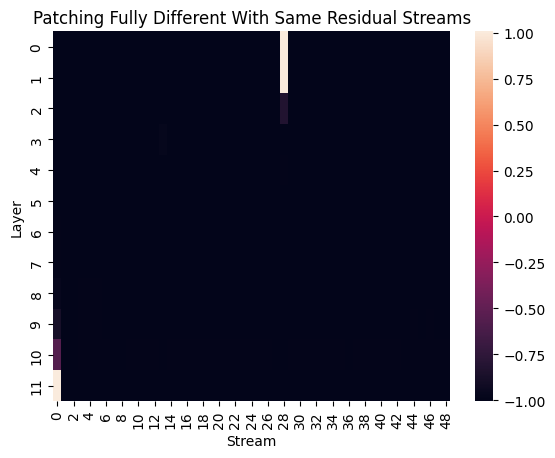

In [106]:
resid_patching(diff, "Patching Fully Different With Same Residual Streams", same_cache)

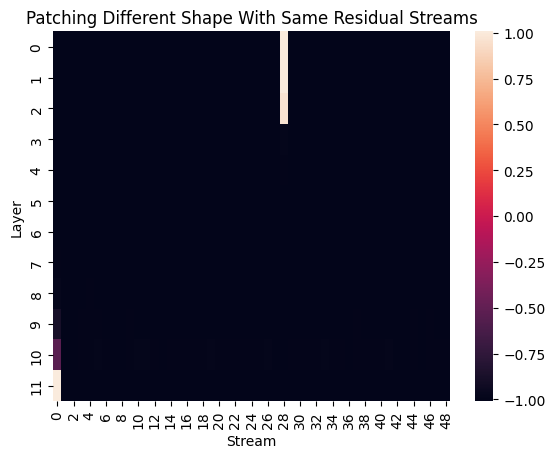

In [107]:
resid_patching(corrupt_shape, "Patching Different Shape With Same Residual Streams", same_cache)

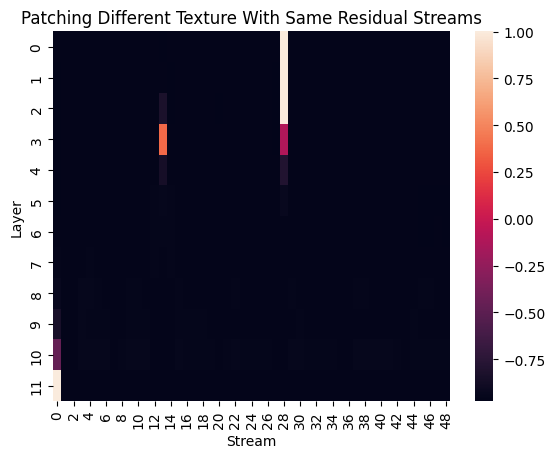

In [108]:
resid_patching(corrupt_texture, "Patching Different Texture With Same Residual Streams", same_cache)

### Layer By Layer Patching

In [112]:
def layer_patching(target_image, title, source_cache):
    patched_attn_diff = torch.zeros(
        tl_model.cfg.n_layers, num_patches, device="cuda", dtype=torch.float32
    )
    patched_mlp_diff = torch.zeros(
        tl_model.cfg.n_layers, num_patches, device="cuda", dtype=torch.float32
    )
    for layer in range(tl_model.cfg.n_layers):
        for position in range(num_patches):
            hook_fn = partial(patch_residual_component, pos=position, source_cache=source_cache)
            patched_attn_logits = tl_model.run_with_hooks(
                target_image,
                fwd_hooks=[(utils.get_act_name("attn_out", layer), hook_fn)],
                return_type="logits",
            )
            patched_attn_logit_diff = get_score(patched_attn_logits)
            
            patched_mlp_logits = tl_model.run_with_hooks(
                target_image,
                fwd_hooks=[(utils.get_act_name("mlp_out", layer), hook_fn)],
                return_type="logits",
            )
            patched_mlp_logit_diff = get_score(patched_mlp_logits)
    
            patched_attn_diff[layer, position] = patched_attn_logit_diff

            patched_mlp_diff[layer, position] = patched_mlp_logit_diff

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,10))
    fig.subplots_adjust(wspace=1)
    
    s =sns.heatmap(patched_attn_diff.cpu(), ax=ax1)
    s.set_title(f"Attn: {title}")
    s.set(xlabel='Stream', ylabel='Layer')

    s =sns.heatmap(patched_mlp_diff.cpu(), ax=ax2)
    s.set_title(f"MLP: {title}")
    s.set(xlabel='Stream', ylabel='Layer')


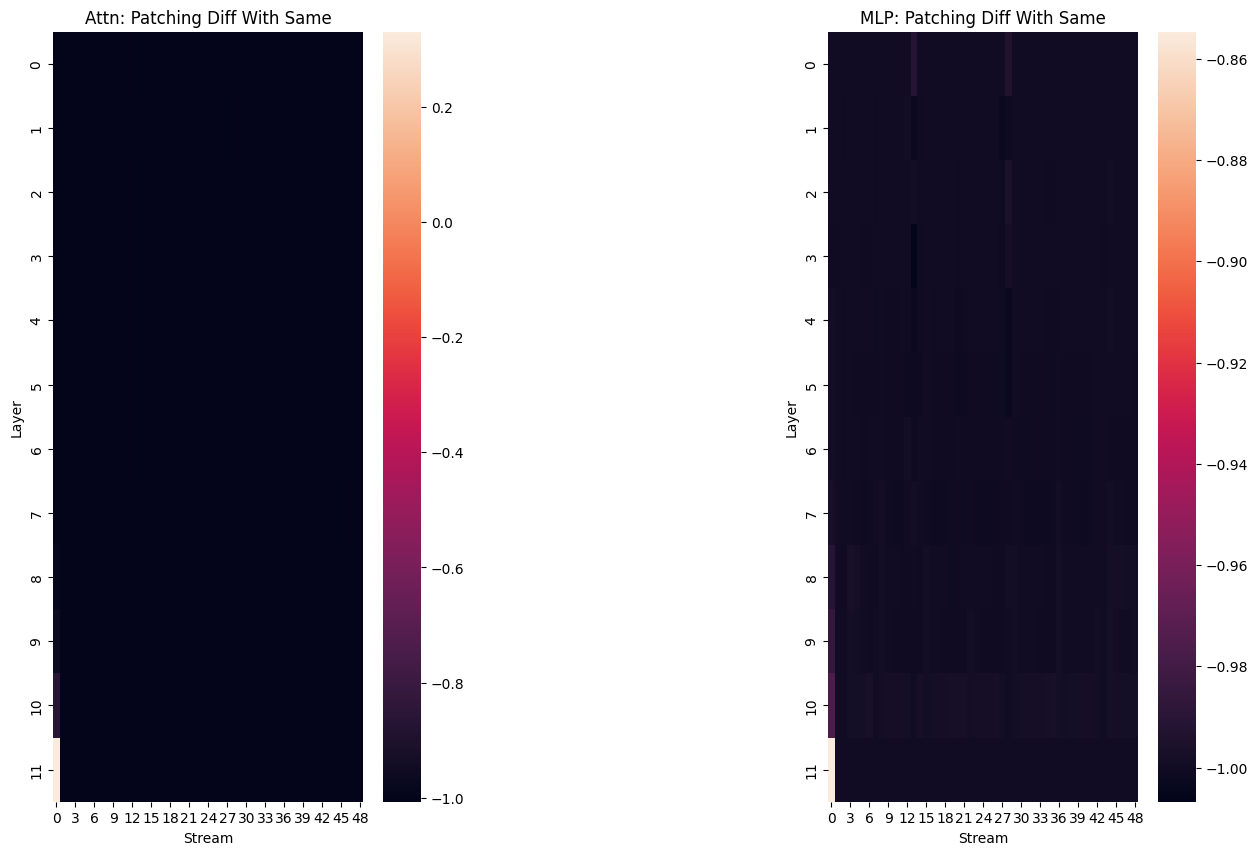

In [113]:
layer_patching(diff, "Patching Diff With Same", same_cache)

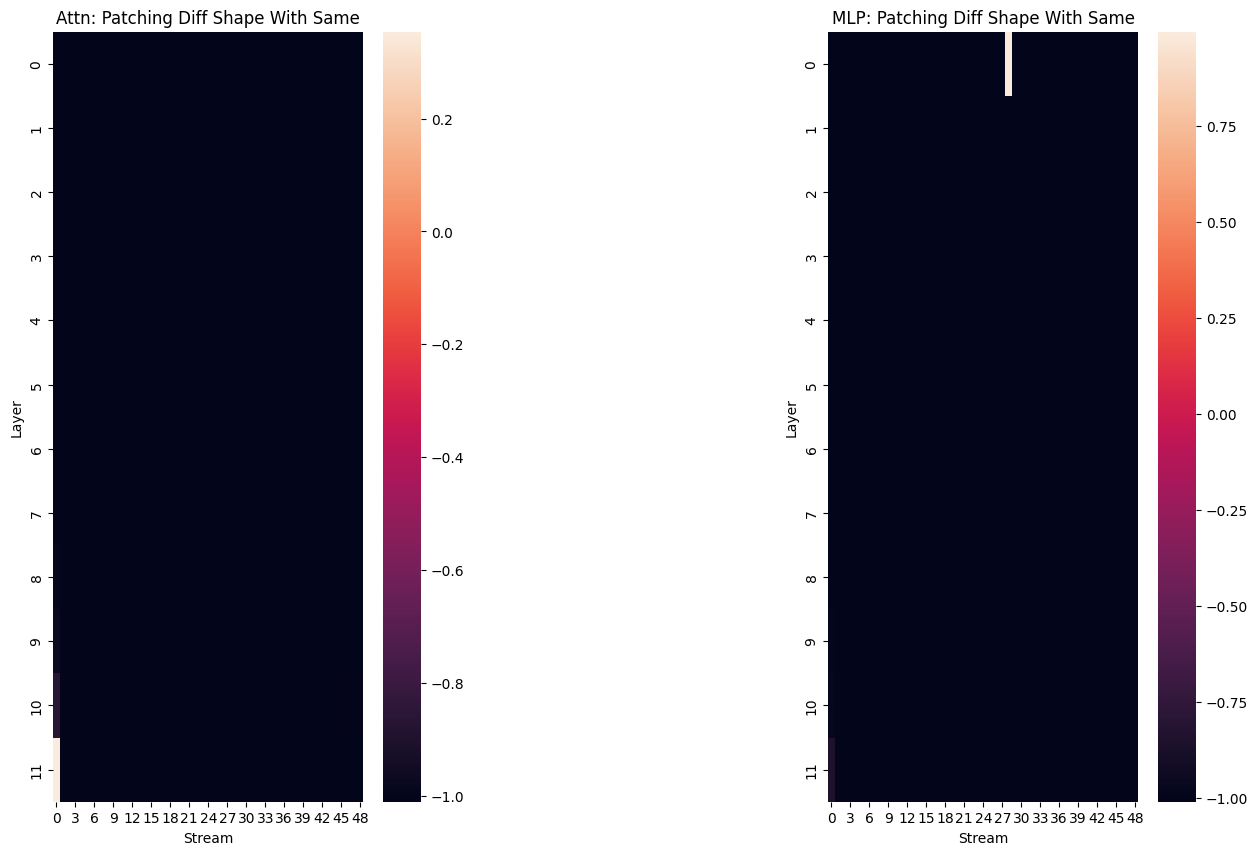

In [114]:
layer_patching(corrupt_shape, "Patching Diff Shape With Same", same_cache)

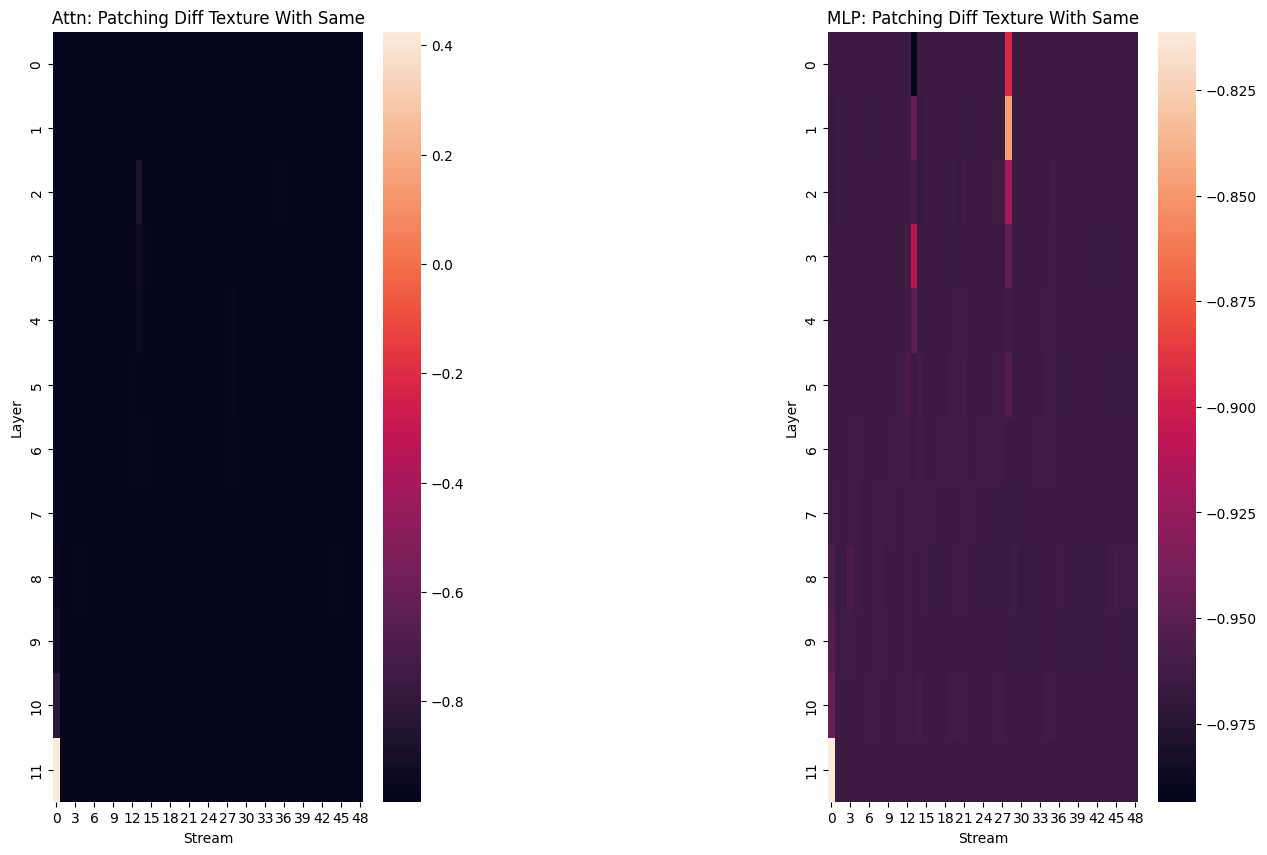

In [115]:
layer_patching(corrupt_texture, "Patching Diff Texture With Same", same_cache)

# Patching Ablation

### Residual Stream Ablation

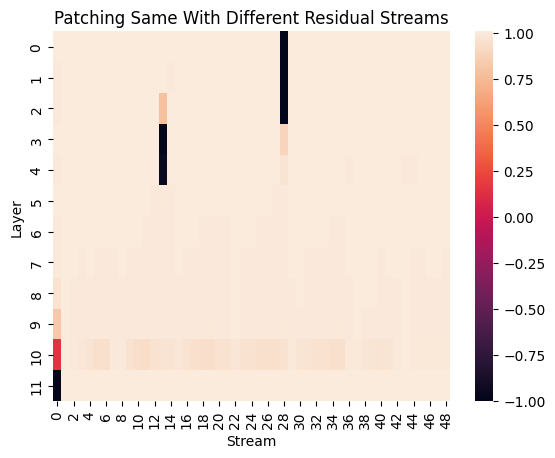

In [116]:
resid_patching(same, "Patching Same With Different Residual Streams", diff_cache)

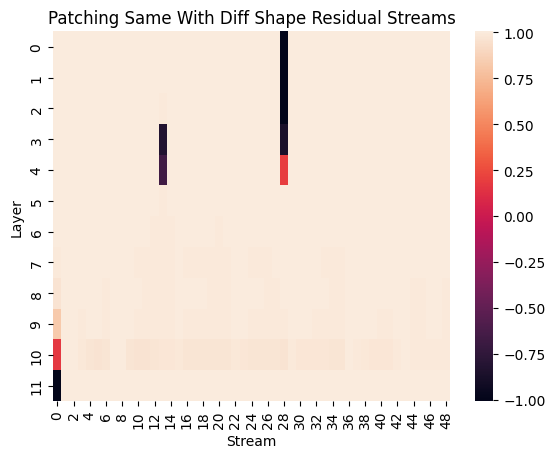

In [118]:
resid_patching(same, "Patching Same With Diff Shape Residual Streams", diff_shape_cache)

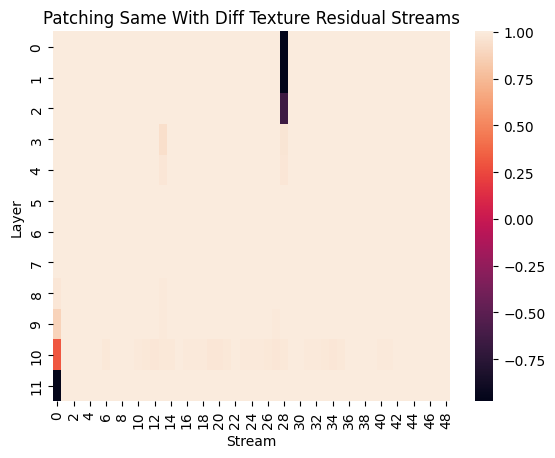

In [120]:
resid_patching(same, "Patching Same With Diff Texture Residual Streams", diff_texture_cache)

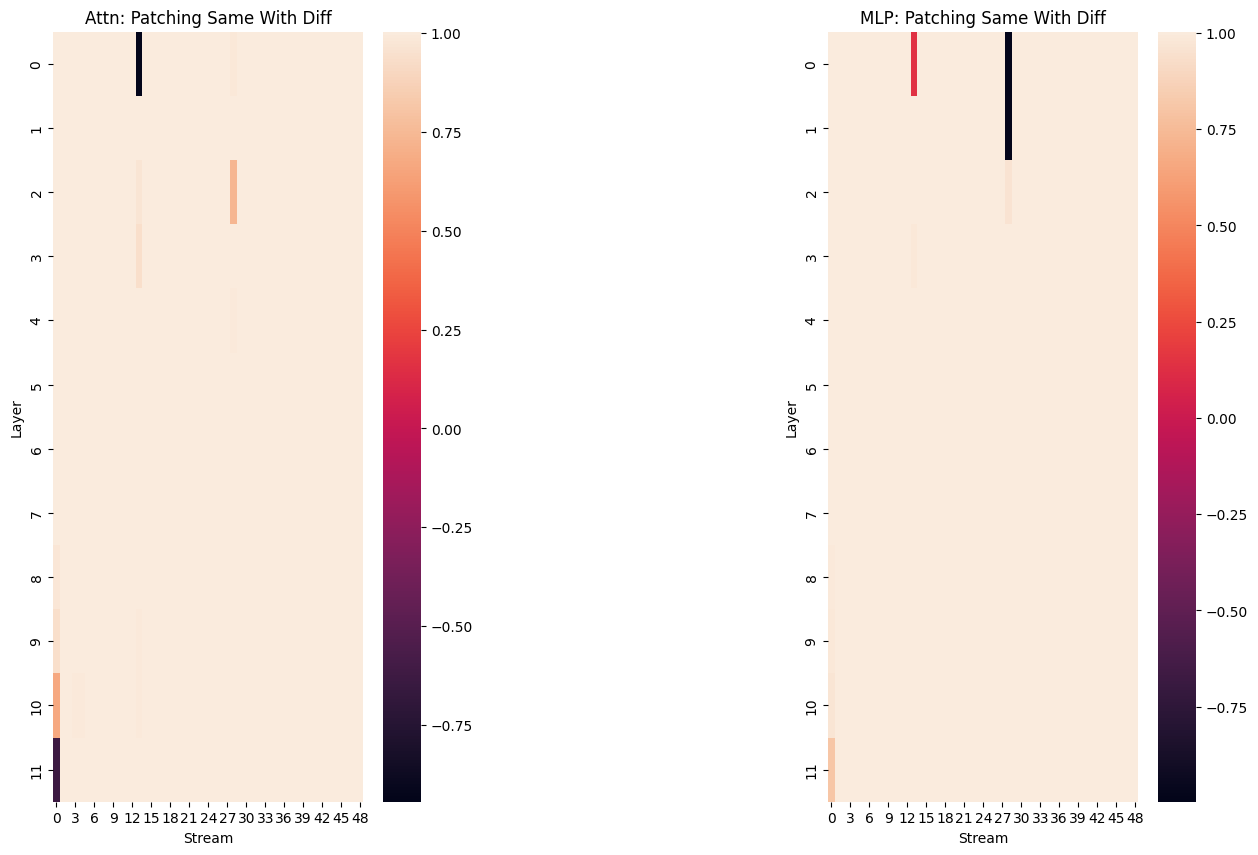

In [121]:
layer_patching(same, "Patching Same With Diff", diff_cache)

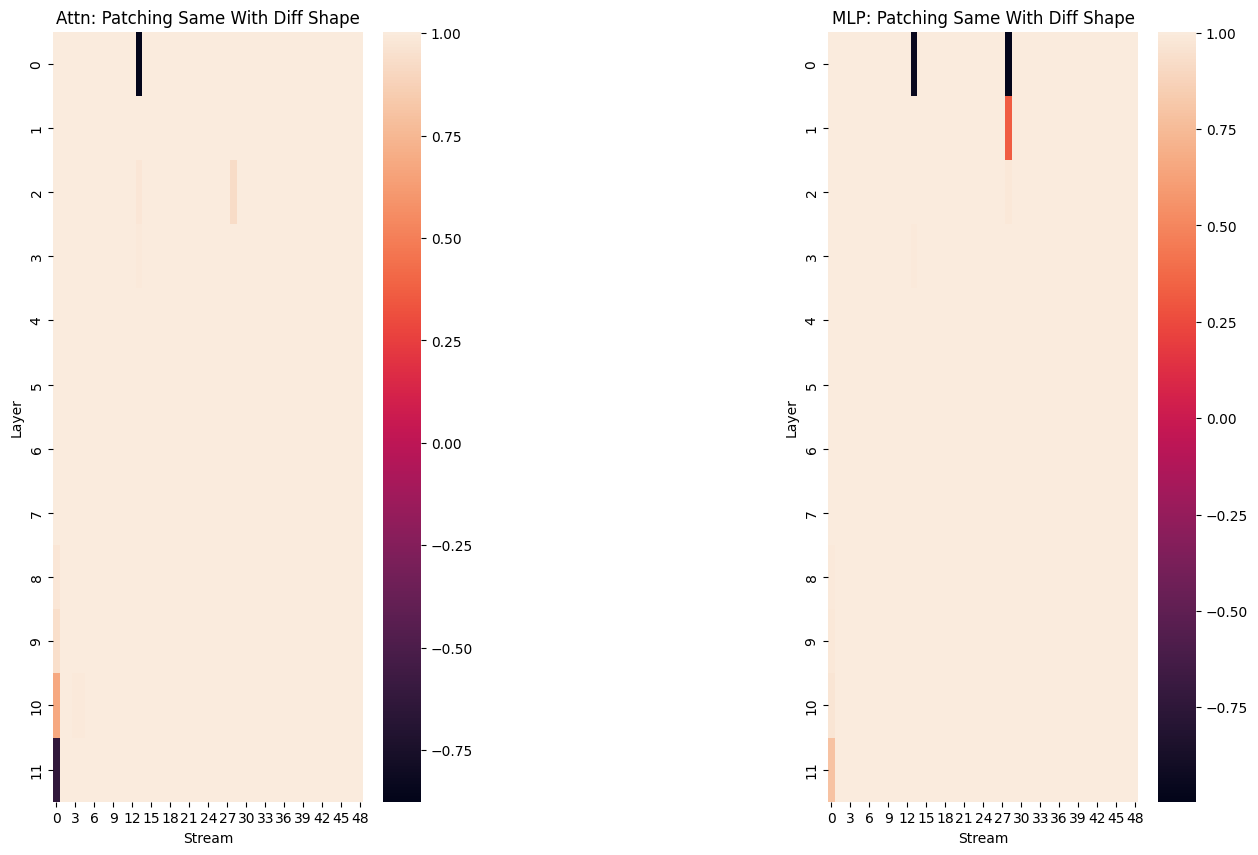

In [122]:
layer_patching(same, "Patching Same With Diff Shape", diff_shape_cache)

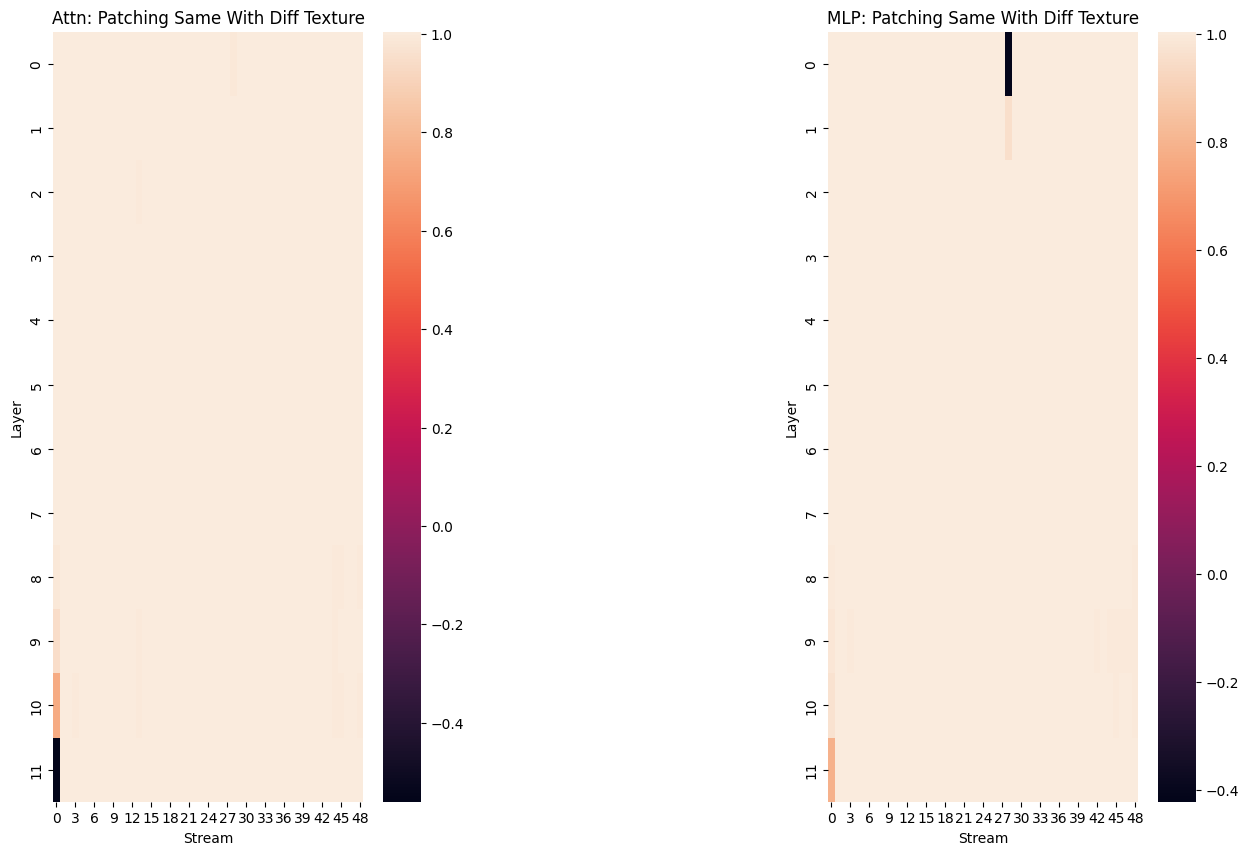

In [123]:
layer_patching(same, "Patching Same With Diff Texture", diff_texture_cache)

# Repeat with From Scratch Model

In [124]:
hf_model.load_state_dict(torch.load("../models/noise_models/scratch_vit32/jhx99r8y.pth"))
state_dict = convert_vit_weights(hf_model, tl_model.cfg)
tl_model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['blocks.0.attn.mask', 'blocks.0.attn.IGNORE', 'blocks.1.attn.mask', 'blocks.1.attn.IGNORE', 'blocks.2.attn.mask', 'blocks.2.attn.IGNORE', 'blocks.3.attn.mask', 'blocks.3.attn.IGNORE', 'blocks.4.attn.mask', 'blocks.4.attn.IGNORE', 'blocks.5.attn.mask', 'blocks.5.attn.IGNORE', 'blocks.6.attn.mask', 'blocks.6.attn.IGNORE', 'blocks.7.attn.mask', 'blocks.7.attn.IGNORE', 'blocks.8.attn.mask', 'blocks.8.attn.IGNORE', 'blocks.9.attn.mask', 'blocks.9.attn.IGNORE', 'blocks.10.attn.mask', 'blocks.10.attn.IGNORE', 'blocks.11.attn.mask', 'blocks.11.attn.IGNORE'], unexpected_keys=[])

In [125]:
print(f"Same Logits: {tl_model(same)}")
print(f"Different Logits: {tl_model(diff)}")
print(f"Different-Shape Logits: {tl_model(corrupt_shape)}")
print(f"Different-Texture Logits: {tl_model(corrupt_texture)}")

Same Logits: tensor([[-2.9956,  3.2034]], device='cuda:0')
Different Logits: tensor([[ 5.8579, -4.8452]], device='cuda:0')
Different-Shape Logits: tensor([[ 6.5646, -6.0321]], device='cuda:0')
Different-Texture Logits: tensor([[ 6.4862, -6.1685]], device='cuda:0')


In [126]:
same_logits, same_cache = tl_model.run_with_cache(same)
diff_logits, diff_cache = tl_model.run_with_cache(diff)
_, diff_shape_cache = tl_model.run_with_cache(corrupt_shape)
_, diff_texture_cache = tl_model.run_with_cache(corrupt_texture)

In [127]:
def get_score(patch_logits, same_logits=same_logits, diff_logits=diff_logits):
    same_logits_diff = same_logits[0, 1] - same_logits[0, 0]
    diff_logits_diff = diff_logits[0, 1] - diff_logits[0, 0]
    patched_logits_diff = patch_logits[0, 1] - patch_logits[0, 0]

    return 2 * (patched_logits_diff - diff_logits_diff)/(same_logits_diff - diff_logits_diff) - 1

### Activation Patching

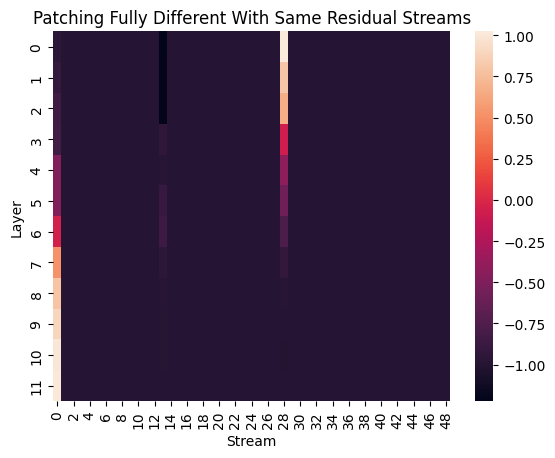

In [128]:
resid_patching(diff, "Patching Fully Different With Same Residual Streams", same_cache)

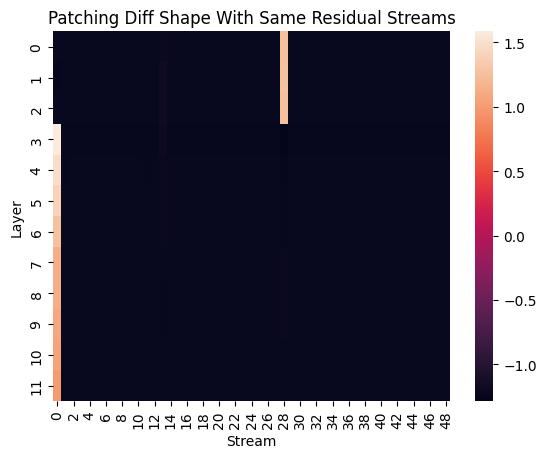

In [135]:
resid_patching(corrupt_shape, "Patching Diff Shape With Same Residual Streams", same_cache)

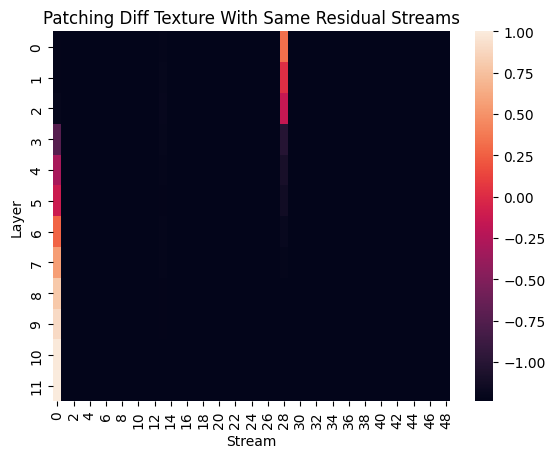

In [136]:
resid_patching(corrupt_texture, "Patching Diff Texture With Same Residual Streams", same_cache)

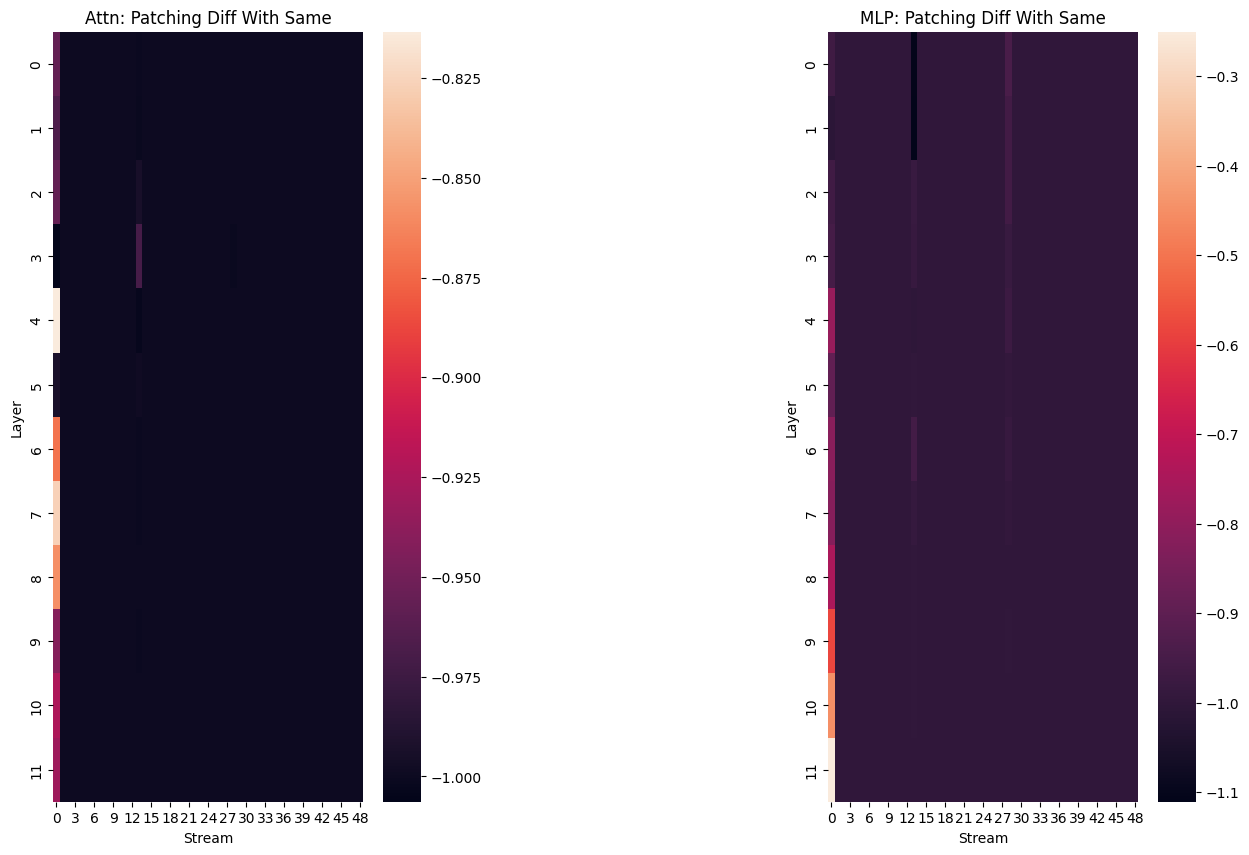

In [137]:
layer_patching(diff, "Patching Diff With Same", same_cache)

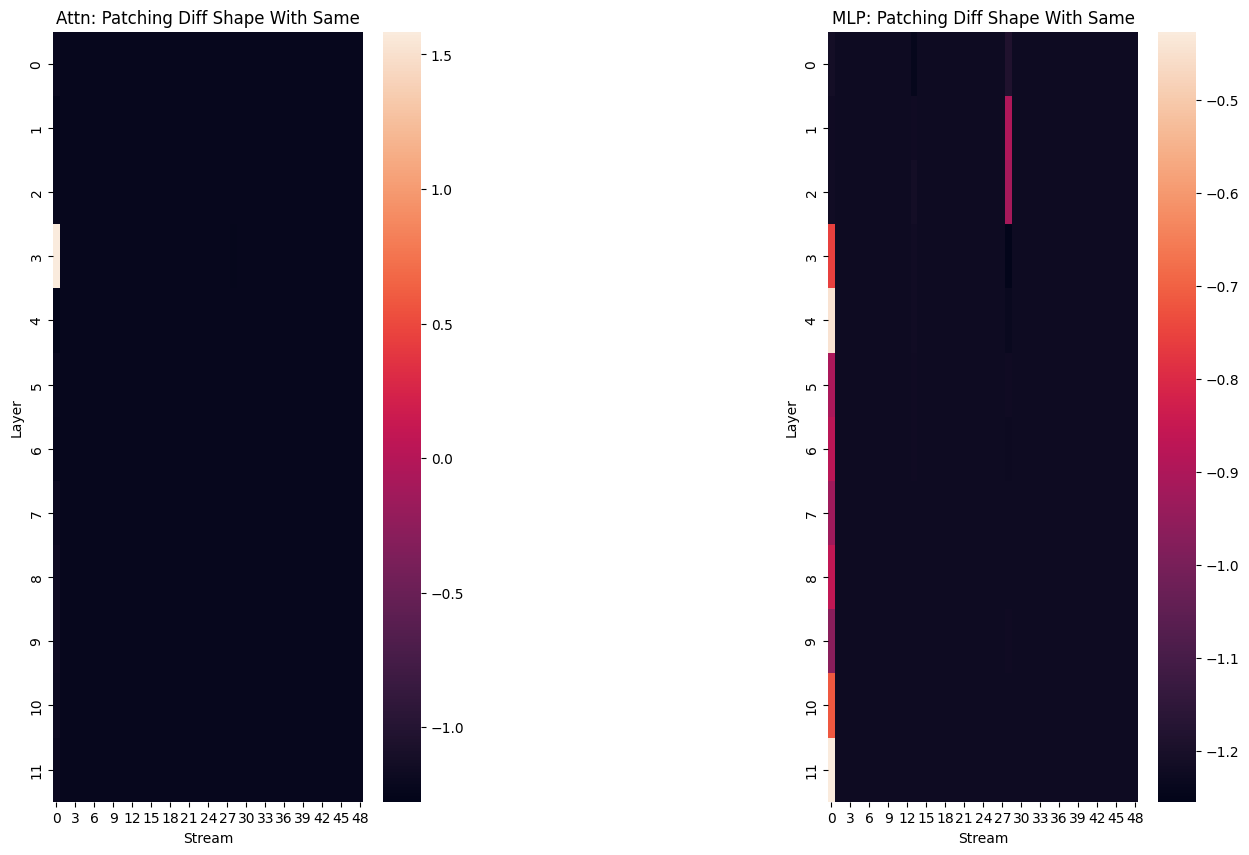

In [139]:
layer_patching(corrupt_shape, "Patching Diff Shape With Same", same_cache)

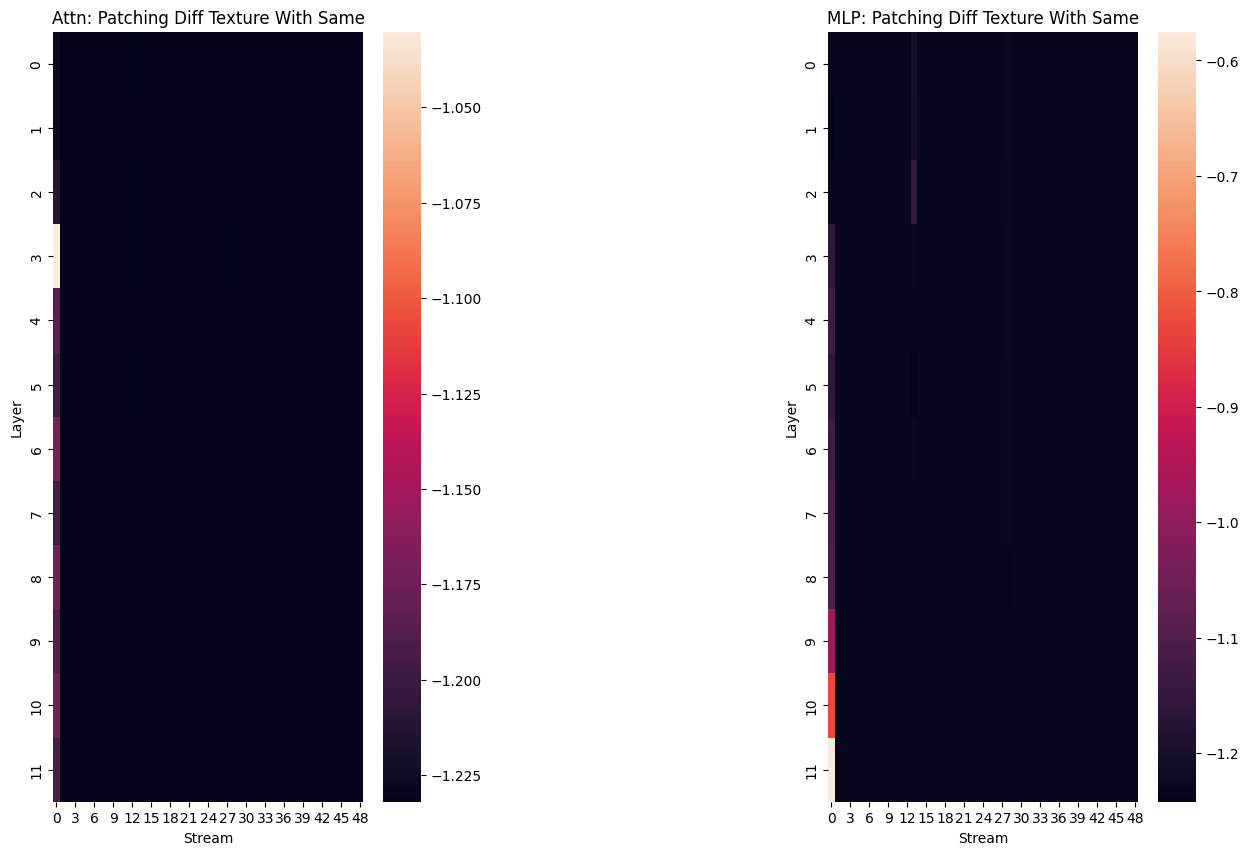

In [140]:
layer_patching(corrupt_texture, "Patching Diff Texture With Same", same_cache)

### Ablation

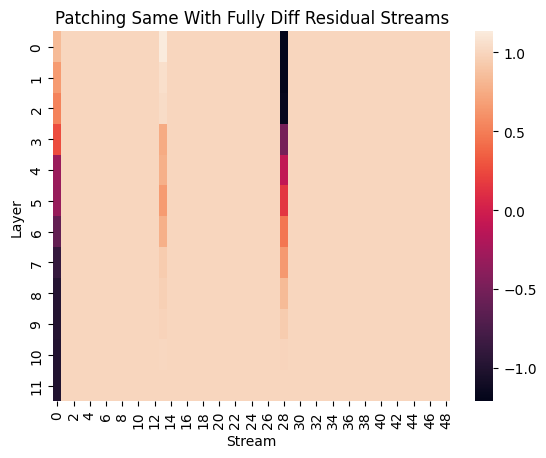

In [134]:
resid_patching(same, "Patching Same With Fully Diff Residual Streams", diff_cache)

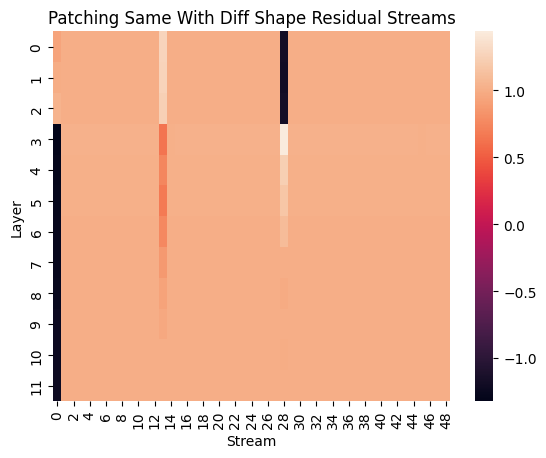

In [129]:
resid_patching(same, "Patching Same With Diff Shape Residual Streams", diff_shape_cache)

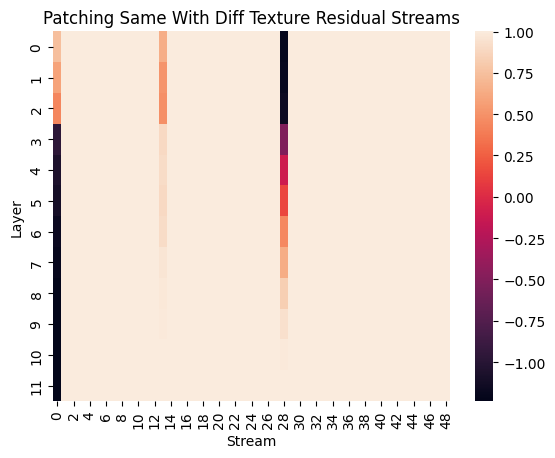

In [130]:
resid_patching(same, "Patching Same With Diff Texture Residual Streams", diff_texture_cache)

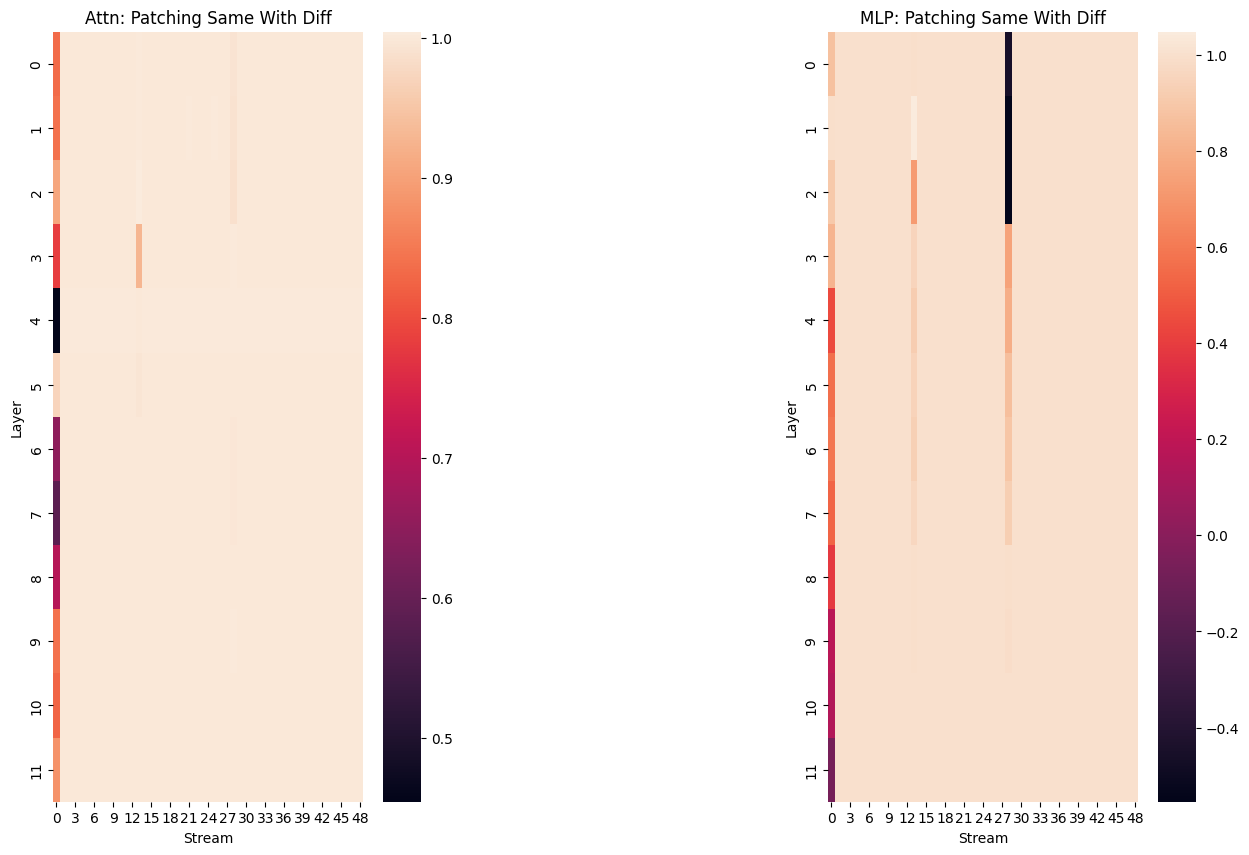

In [131]:
layer_patching(same, "Patching Same With Diff", diff_cache)

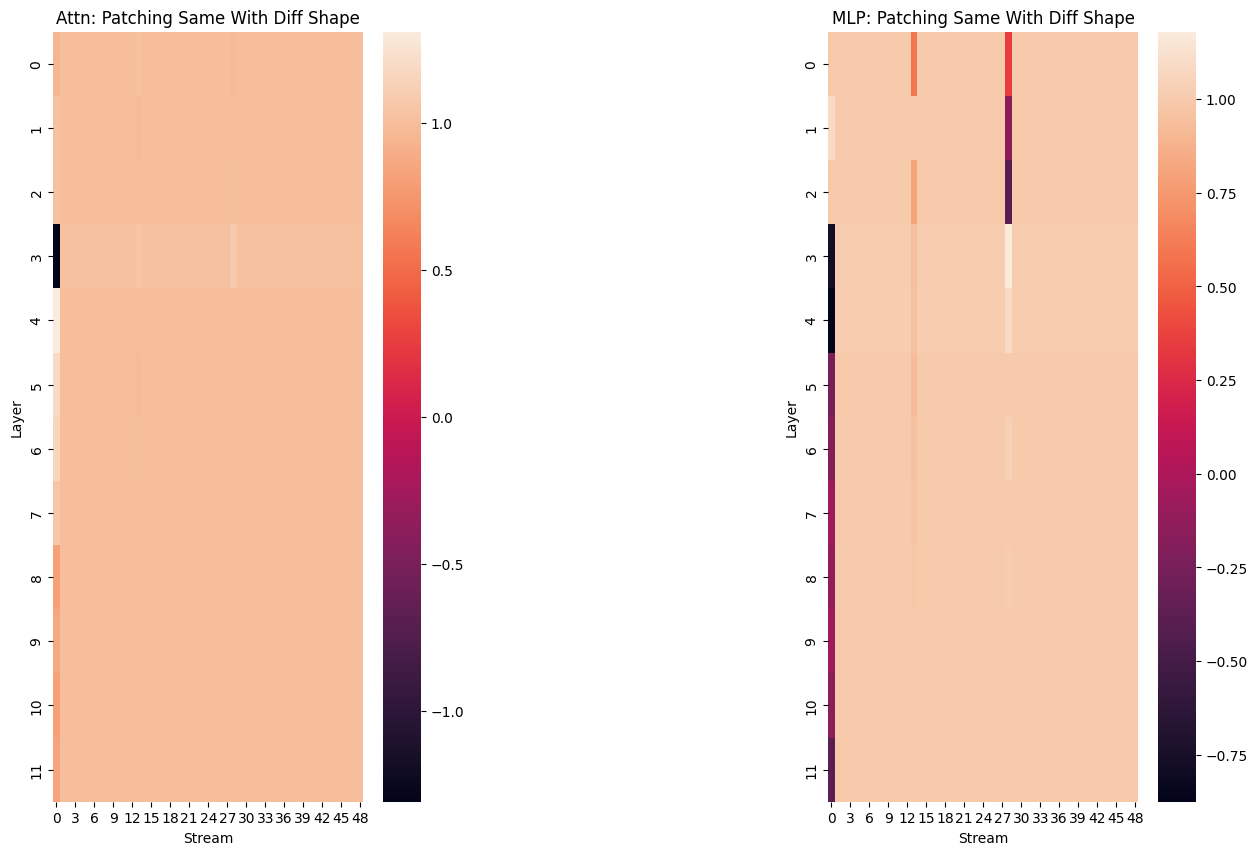

In [132]:
layer_patching(same, "Patching Same With Diff Shape", diff_shape_cache)

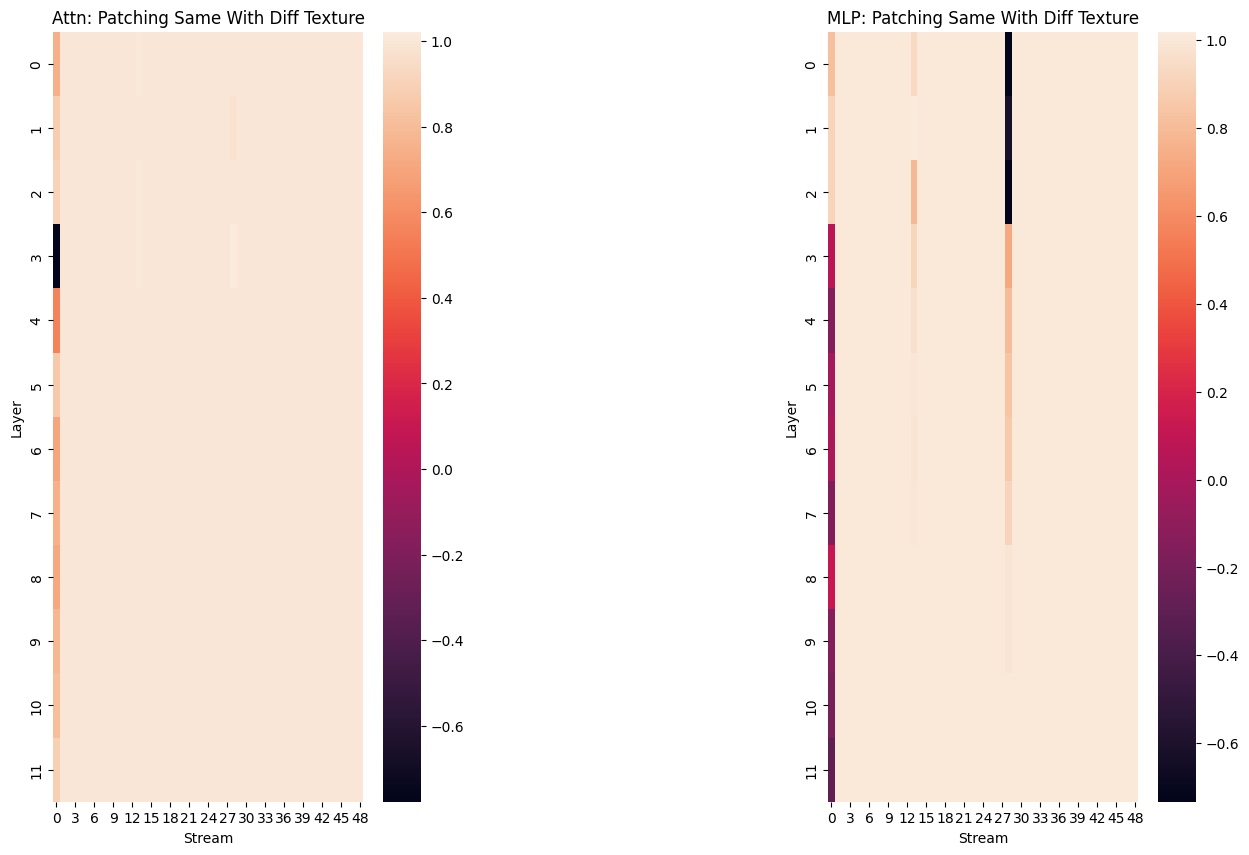

In [133]:
layer_patching(same, "Patching Same With Diff Texture", diff_texture_cache)

# Do the same with CLIP

In [143]:
from transformers import AutoProcessor, CLIPVisionModelWithProjection
from transformer_lens.HookedViT import HookedViT

image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
hf_model = CLIPVisionModelWithProjection.from_pretrained("openai/clip-vit-base-patch32").to("cuda")
tl_model = HookedViT.from_pretrained("openai/clip-vit-base-patch32", is_clip=True).to("cuda")

import torch

hf_model.load_state_dict(torch.load("../models/noise_models/clip_vit32/vdqfpb62.pth"))

from transformer_lens.loading_from_pretrained import convert_clip_weights

state_dict = convert_vit_weights(hf_model, tl_model.cfg)
tl_model.load_state_dict(state_dict, strict=False)

If using ViT for interpretability research, keep in mind that ViT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  cuda
Loaded pretrained model openai/clip-vit-base-patch32 into HookedTransformer
Moving model to device:  cuda


RuntimeError: Error(s) in loading state_dict for CLIPVisionModelWithProjection:
	Unexpected key(s) in state_dict: "visual_projection.bias". 
	size mismatch for visual_projection.weight: copying a param with shape torch.Size([2, 768]) from checkpoint, the shape in current model is torch.Size([512, 768]).